In [32]:
import numpy as np
import random
from statistics import mean, stdev
import matplotlib.pyplot as plt
from collections import Counter
from uncertainties import ufloat
from uncertainties.umath import *
import itertools

sentinel = object()

def zip_longest_no_fill(*args):
    for i in itertools.zip_longest(*args, fillvalue=sentinel):
        yield tuple(x for x in i if x is not sentinel)

class Org:
    def __init__(self,cladeID,geneValue,advantage):
        self.cladeID = cladeID
        self.geneValue = geneValue #(0,1,2)
        self.advantage = advantage
        self.fitness = advantage**geneValue

    def makeMutatedOffspring(self,):
        return Org(self.cladeID,self.geneValue,self.advantage)
        
def roulette(population,batchSize,exponent):
    MAX = max([org.fitness for org in population])
    F = [np.power(exponent,org.fitness-MAX) for org in population]
    S = sum(F)
    return random.choices(list(range(len(population))),k=batchSize,weights=[f/S for f in F])

def dictionaryReduce(listOfDict,target):
    #NOTE: if the target and listOfDict both lack a key,
    #      the updated target will not contain an entry for that key:
    #      this function aims to include zeros for missing keys
    #      therefore, some entries may lack zeros if they are not 
    #      represented in the initial set of keys provided; this function is
    #      best used when listOfDict is the final set of dics to be reduced
    maxKey = max([max(d.keys()) for d in listOfDict]+[max(list(target.keys())+[-1])])
    for dic in listOfDict:
        for key in range(maxKey+1):
            if key not in target:
                target[key] = []
            target[key].append(dic[key])
    return target

In [2]:

TPM_MEMO = {}
def moranTPM(Ni,Nf):
    global TPM_MEMO
    key = (Ni,Nf)
#     print("MDKEY",key)
    if key not in TPM_MEMO:
        TPM = []
        if Ni == Nf:
#             print("same")
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Ni+1):
                    #from row to column
                    if col == row-1:
                        #probability to loose one descendant count
                        TPM[row].append((1-(row/Ni))*(row/Ni) if Ni>0 else 0.)
                    elif col == row:
                        #probability to stay at the same count
                        TPM[row].append((row/Ni)**2 + (1-(row/Ni))**2 if Ni>0 else 1.)
                    elif col == row+1:
                        #probability to increase descendant count
                        TPM[row].append((row/Ni)*(1-(row/Ni)) if Ni>0 else 0.)
                    else:
                        TPM[row].append(0.0)
        elif Ni+1 == Nf:
#             print("inc")
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Nf+1):
                    #from row to column
                    if col == row:
                        #probability to stay at the same count
                        TPM[row].append(1-(row/Ni) if Ni>0 else 1.)
                    elif col == row+1:
                        #probability to increase descendant count
                        TPM[row].append(row/Ni if Ni>0 else 0.)
                    else:
                        TPM[row].append(0.0)
        elif Ni-1 == Nf:
#             print("dec")
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Nf+1):
                    #from row to column
                    if col == row-1:
                        #probability to loose one descendant count
                        TPM[row].append(row/Ni if Ni>0 else 0.)
                    elif col == row:
                        #probability to stay at the same count
                        TPM[row].append(1-(row/Ni) if Ni>0 else 1.)
                    else:
                        TPM[row].append(0.0)
        else:
            print("ERROR: Invalid population sizes in moran drift reference.")
            return None
        TPM_MEMO[key] = np.array(TPM)
#         print(key)
#         print(np.array(TPM))
        
    else:
        TPM = TPM_MEMO[key]
         
    return TPM

def moranDriftReference(popSizeHistory):
    Xnp = np.array([0.,1.]+[0. for _ in range(popSizeHistory[0]-1)])
    for Ni,Nf in zip(popSizeHistory[:-1],popSizeHistory[1:]):
        TPMnp = np.array(moranTPM(Ni,Nf))
        Xnp = np.dot(Xnp,TPMnp)
    return Xnp

In [13]:

STR = float(10)
ADV = 1.5
# N = 3*100

metaLog = []
totalReps = 10000
for REP in range(totalReps):
    print(REP+1,(REP+1)/totalReps)
#     seedSize = 50
#     population = [Org(i, 0,ADV)for i in range(N-2*seedSize)] + [Org(i+N-seedSize, 1,ADV)for i in range(seedSize)] + [Org(i+N-2*seedSize, 2,ADV)for i in range(seedSize)]
#     population = [Org(i, i//(N//3),ADV) for i in range(N)]
    population = [Org(i, 0, ADV) for i in range(200)]
    population += [Org(i, 1, ADV) for i in range(40)]
    population += [Org(i, 2, ADV) for i in range(10)]
    N = len(population)
    U = N

    groupSizeLog = [[sum([1 for org in population if org.geneValue == 0])],
                     [sum([1 for org in population if org.geneValue == 1])],
                     [sum([1 for org in population if org.geneValue == 2])],
                     [sum([1 for org in population if org.geneValue in [2,1]])],
                     [sum([1 for org in population if org.geneValue in [0,1]])],
                     [sum([1 for org in population if org.geneValue in [2,0]])]
                   ]
#     print(groupSizeLog)

    fitnessLog = [mean([org.fitness for org in population])]
    for u in range(U):
        participated = []
        birthIDs = roulette(population,1,STR)
        participated.append(population[birthIDs[0]].geneValue)
        deathID = random.randint(0,len(population)-1)
        participated.append(population[deathID].geneValue)
        child = population[birthIDs[0]].makeMutatedOffspring()
        population[deathID] = child
        #old accounting method, over counts no-op updates
    #     groupSizeLog.append([sum([1 for org in population if org.geneValue == 0]),
    #                  sum([1 for org in population if org.geneValue == 1]),
    #                  sum([1 for org in population if org.geneValue == 2])])
    
        #new accounting method, skips no-op updates
        for gv in range(3):
            if gv in participated:
                groupSizeLog[gv].append(sum([1 for org in population if org.geneValue == gv]))
                
        if 2 in participated or 1 in participated:
            groupSizeLog[3].append(sum([1 for org in population if org.geneValue in [2,1]]))
            
        if 0 in participated or 1 in participated:
            groupSizeLog[4].append(sum([1 for org in population if org.geneValue in [0,1]]))
            
        if 0 in participated or 2 in participated:
            groupSizeLog[5].append(sum([1 for org in population if org.geneValue in [2,0]]))
            
        fitnessLog.append(mean([org.fitness for org in population]))
        
    metaLog.append([groupSizeLog,fitnessLog,[org.cladeID for org in population],
                   [org.cladeID for org in population if org.geneValue == 0],#A
                   [org.cladeID for org in population if org.geneValue == 1],#B
                   [org.cladeID for org in population if org.geneValue == 2],#C
                   [org.cladeID for org in population if org.geneValue in [2,1]],#BC
                   [org.cladeID for org in population if org.geneValue in [0,1]],#AB
                   [org.cladeID for org in population if org.geneValue in [2,0]],#AC
                   ])


1 0.0001
2 0.0002
3 0.0003
4 0.0004
5 0.0005
6 0.0006
7 0.0007
8 0.0008
9 0.0009
10 0.001
11 0.0011
12 0.0012
13 0.0013
14 0.0014
15 0.0015
16 0.0016
17 0.0017
18 0.0018
19 0.0019
20 0.002
21 0.0021
22 0.0022
23 0.0023
24 0.0024
25 0.0025
26 0.0026
27 0.0027
28 0.0028
29 0.0029
30 0.003
31 0.0031
32 0.0032
33 0.0033
34 0.0034
35 0.0035
36 0.0036
37 0.0037
38 0.0038
39 0.0039
40 0.004
41 0.0041
42 0.0042
43 0.0043
44 0.0044
45 0.0045
46 0.0046
47 0.0047
48 0.0048
49 0.0049
50 0.005
51 0.0051
52 0.0052
53 0.0053
54 0.0054
55 0.0055
56 0.0056
57 0.0057
58 0.0058
59 0.0059
60 0.006
61 0.0061
62 0.0062
63 0.0063
64 0.0064
65 0.0065
66 0.0066
67 0.0067
68 0.0068
69 0.0069
70 0.007
71 0.0071
72 0.0072
73 0.0073
74 0.0074
75 0.0075
76 0.0076
77 0.0077
78 0.0078
79 0.0079
80 0.008
81 0.0081
82 0.0082
83 0.0083
84 0.0084
85 0.0085
86 0.0086
87 0.0087
88 0.0088
89 0.0089
90 0.009
91 0.0091
92 0.0092
93 0.0093
94 0.0094
95 0.0095
96 0.0096
97 0.0097
98 0.0098
99 0.0099
100 0.01
101 0.0101
102 0.01

767 0.0767
768 0.0768
769 0.0769
770 0.077
771 0.0771
772 0.0772
773 0.0773
774 0.0774
775 0.0775
776 0.0776
777 0.0777
778 0.0778
779 0.0779
780 0.078
781 0.0781
782 0.0782
783 0.0783
784 0.0784
785 0.0785
786 0.0786
787 0.0787
788 0.0788
789 0.0789
790 0.079
791 0.0791
792 0.0792
793 0.0793
794 0.0794
795 0.0795
796 0.0796
797 0.0797
798 0.0798
799 0.0799
800 0.08
801 0.0801
802 0.0802
803 0.0803
804 0.0804
805 0.0805
806 0.0806
807 0.0807
808 0.0808
809 0.0809
810 0.081
811 0.0811
812 0.0812
813 0.0813
814 0.0814
815 0.0815
816 0.0816
817 0.0817
818 0.0818
819 0.0819
820 0.082
821 0.0821
822 0.0822
823 0.0823
824 0.0824
825 0.0825
826 0.0826
827 0.0827
828 0.0828
829 0.0829
830 0.083
831 0.0831
832 0.0832
833 0.0833
834 0.0834
835 0.0835
836 0.0836
837 0.0837
838 0.0838
839 0.0839
840 0.084
841 0.0841
842 0.0842
843 0.0843
844 0.0844
845 0.0845
846 0.0846
847 0.0847
848 0.0848
849 0.0849
850 0.085
851 0.0851
852 0.0852
853 0.0853
854 0.0854
855 0.0855
856 0.0856
857 0.0857
858 0.085

1476 0.1476
1477 0.1477
1478 0.1478
1479 0.1479
1480 0.148
1481 0.1481
1482 0.1482
1483 0.1483
1484 0.1484
1485 0.1485
1486 0.1486
1487 0.1487
1488 0.1488
1489 0.1489
1490 0.149
1491 0.1491
1492 0.1492
1493 0.1493
1494 0.1494
1495 0.1495
1496 0.1496
1497 0.1497
1498 0.1498
1499 0.1499
1500 0.15
1501 0.1501
1502 0.1502
1503 0.1503
1504 0.1504
1505 0.1505
1506 0.1506
1507 0.1507
1508 0.1508
1509 0.1509
1510 0.151
1511 0.1511
1512 0.1512
1513 0.1513
1514 0.1514
1515 0.1515
1516 0.1516
1517 0.1517
1518 0.1518
1519 0.1519
1520 0.152
1521 0.1521
1522 0.1522
1523 0.1523
1524 0.1524
1525 0.1525
1526 0.1526
1527 0.1527
1528 0.1528
1529 0.1529
1530 0.153
1531 0.1531
1532 0.1532
1533 0.1533
1534 0.1534
1535 0.1535
1536 0.1536
1537 0.1537
1538 0.1538
1539 0.1539
1540 0.154
1541 0.1541
1542 0.1542
1543 0.1543
1544 0.1544
1545 0.1545
1546 0.1546
1547 0.1547
1548 0.1548
1549 0.1549
1550 0.155
1551 0.1551
1552 0.1552
1553 0.1553
1554 0.1554
1555 0.1555
1556 0.1556
1557 0.1557
1558 0.1558
1559 0.1559
1

2168 0.2168
2169 0.2169
2170 0.217
2171 0.2171
2172 0.2172
2173 0.2173
2174 0.2174
2175 0.2175
2176 0.2176
2177 0.2177
2178 0.2178
2179 0.2179
2180 0.218
2181 0.2181
2182 0.2182
2183 0.2183
2184 0.2184
2185 0.2185
2186 0.2186
2187 0.2187
2188 0.2188
2189 0.2189
2190 0.219
2191 0.2191
2192 0.2192
2193 0.2193
2194 0.2194
2195 0.2195
2196 0.2196
2197 0.2197
2198 0.2198
2199 0.2199
2200 0.22
2201 0.2201
2202 0.2202
2203 0.2203
2204 0.2204
2205 0.2205
2206 0.2206
2207 0.2207
2208 0.2208
2209 0.2209
2210 0.221
2211 0.2211
2212 0.2212
2213 0.2213
2214 0.2214
2215 0.2215
2216 0.2216
2217 0.2217
2218 0.2218
2219 0.2219
2220 0.222
2221 0.2221
2222 0.2222
2223 0.2223
2224 0.2224
2225 0.2225
2226 0.2226
2227 0.2227
2228 0.2228
2229 0.2229
2230 0.223
2231 0.2231
2232 0.2232
2233 0.2233
2234 0.2234
2235 0.2235
2236 0.2236
2237 0.2237
2238 0.2238
2239 0.2239
2240 0.224
2241 0.2241
2242 0.2242
2243 0.2243
2244 0.2244
2245 0.2245
2246 0.2246
2247 0.2247
2248 0.2248
2249 0.2249
2250 0.225
2251 0.2251
22

2862 0.2862
2863 0.2863
2864 0.2864
2865 0.2865
2866 0.2866
2867 0.2867
2868 0.2868
2869 0.2869
2870 0.287
2871 0.2871
2872 0.2872
2873 0.2873
2874 0.2874
2875 0.2875
2876 0.2876
2877 0.2877
2878 0.2878
2879 0.2879
2880 0.288
2881 0.2881
2882 0.2882
2883 0.2883
2884 0.2884
2885 0.2885
2886 0.2886
2887 0.2887
2888 0.2888
2889 0.2889
2890 0.289
2891 0.2891
2892 0.2892
2893 0.2893
2894 0.2894
2895 0.2895
2896 0.2896
2897 0.2897
2898 0.2898
2899 0.2899
2900 0.29
2901 0.2901
2902 0.2902
2903 0.2903
2904 0.2904
2905 0.2905
2906 0.2906
2907 0.2907
2908 0.2908
2909 0.2909
2910 0.291
2911 0.2911
2912 0.2912
2913 0.2913
2914 0.2914
2915 0.2915
2916 0.2916
2917 0.2917
2918 0.2918
2919 0.2919
2920 0.292
2921 0.2921
2922 0.2922
2923 0.2923
2924 0.2924
2925 0.2925
2926 0.2926
2927 0.2927
2928 0.2928
2929 0.2929
2930 0.293
2931 0.2931
2932 0.2932
2933 0.2933
2934 0.2934
2935 0.2935
2936 0.2936
2937 0.2937
2938 0.2938
2939 0.2939
2940 0.294
2941 0.2941
2942 0.2942
2943 0.2943
2944 0.2944
2945 0.2945
2

3556 0.3556
3557 0.3557
3558 0.3558
3559 0.3559
3560 0.356
3561 0.3561
3562 0.3562
3563 0.3563
3564 0.3564
3565 0.3565
3566 0.3566
3567 0.3567
3568 0.3568
3569 0.3569
3570 0.357
3571 0.3571
3572 0.3572
3573 0.3573
3574 0.3574
3575 0.3575
3576 0.3576
3577 0.3577
3578 0.3578
3579 0.3579
3580 0.358
3581 0.3581
3582 0.3582
3583 0.3583
3584 0.3584
3585 0.3585
3586 0.3586
3587 0.3587
3588 0.3588
3589 0.3589
3590 0.359
3591 0.3591
3592 0.3592
3593 0.3593
3594 0.3594
3595 0.3595
3596 0.3596
3597 0.3597
3598 0.3598
3599 0.3599
3600 0.36
3601 0.3601
3602 0.3602
3603 0.3603
3604 0.3604
3605 0.3605
3606 0.3606
3607 0.3607
3608 0.3608
3609 0.3609
3610 0.361
3611 0.3611
3612 0.3612
3613 0.3613
3614 0.3614
3615 0.3615
3616 0.3616
3617 0.3617
3618 0.3618
3619 0.3619
3620 0.362
3621 0.3621
3622 0.3622
3623 0.3623
3624 0.3624
3625 0.3625
3626 0.3626
3627 0.3627
3628 0.3628
3629 0.3629
3630 0.363
3631 0.3631
3632 0.3632
3633 0.3633
3634 0.3634
3635 0.3635
3636 0.3636
3637 0.3637
3638 0.3638
3639 0.3639
3

4250 0.425
4251 0.4251
4252 0.4252
4253 0.4253
4254 0.4254
4255 0.4255
4256 0.4256
4257 0.4257
4258 0.4258
4259 0.4259
4260 0.426
4261 0.4261
4262 0.4262
4263 0.4263
4264 0.4264
4265 0.4265
4266 0.4266
4267 0.4267
4268 0.4268
4269 0.4269
4270 0.427
4271 0.4271
4272 0.4272
4273 0.4273
4274 0.4274
4275 0.4275
4276 0.4276
4277 0.4277
4278 0.4278
4279 0.4279
4280 0.428
4281 0.4281
4282 0.4282
4283 0.4283
4284 0.4284
4285 0.4285
4286 0.4286
4287 0.4287
4288 0.4288
4289 0.4289
4290 0.429
4291 0.4291
4292 0.4292
4293 0.4293
4294 0.4294
4295 0.4295
4296 0.4296
4297 0.4297
4298 0.4298
4299 0.4299
4300 0.43
4301 0.4301
4302 0.4302
4303 0.4303
4304 0.4304
4305 0.4305
4306 0.4306
4307 0.4307
4308 0.4308
4309 0.4309
4310 0.431
4311 0.4311
4312 0.4312
4313 0.4313
4314 0.4314
4315 0.4315
4316 0.4316
4317 0.4317
4318 0.4318
4319 0.4319
4320 0.432
4321 0.4321
4322 0.4322
4323 0.4323
4324 0.4324
4325 0.4325
4326 0.4326
4327 0.4327
4328 0.4328
4329 0.4329
4330 0.433
4331 0.4331
4332 0.4332
4333 0.4333
43

4941 0.4941
4942 0.4942
4943 0.4943
4944 0.4944
4945 0.4945
4946 0.4946
4947 0.4947
4948 0.4948
4949 0.4949
4950 0.495
4951 0.4951
4952 0.4952
4953 0.4953
4954 0.4954
4955 0.4955
4956 0.4956
4957 0.4957
4958 0.4958
4959 0.4959
4960 0.496
4961 0.4961
4962 0.4962
4963 0.4963
4964 0.4964
4965 0.4965
4966 0.4966
4967 0.4967
4968 0.4968
4969 0.4969
4970 0.497
4971 0.4971
4972 0.4972
4973 0.4973
4974 0.4974
4975 0.4975
4976 0.4976
4977 0.4977
4978 0.4978
4979 0.4979
4980 0.498
4981 0.4981
4982 0.4982
4983 0.4983
4984 0.4984
4985 0.4985
4986 0.4986
4987 0.4987
4988 0.4988
4989 0.4989
4990 0.499
4991 0.4991
4992 0.4992
4993 0.4993
4994 0.4994
4995 0.4995
4996 0.4996
4997 0.4997
4998 0.4998
4999 0.4999
5000 0.5
5001 0.5001
5002 0.5002
5003 0.5003
5004 0.5004
5005 0.5005
5006 0.5006
5007 0.5007
5008 0.5008
5009 0.5009
5010 0.501
5011 0.5011
5012 0.5012
5013 0.5013
5014 0.5014
5015 0.5015
5016 0.5016
5017 0.5017
5018 0.5018
5019 0.5019
5020 0.502
5021 0.5021
5022 0.5022
5023 0.5023
5024 0.5024
50

5634 0.5634
5635 0.5635
5636 0.5636
5637 0.5637
5638 0.5638
5639 0.5639
5640 0.564
5641 0.5641
5642 0.5642
5643 0.5643
5644 0.5644
5645 0.5645
5646 0.5646
5647 0.5647
5648 0.5648
5649 0.5649
5650 0.565
5651 0.5651
5652 0.5652
5653 0.5653
5654 0.5654
5655 0.5655
5656 0.5656
5657 0.5657
5658 0.5658
5659 0.5659
5660 0.566
5661 0.5661
5662 0.5662
5663 0.5663
5664 0.5664
5665 0.5665
5666 0.5666
5667 0.5667
5668 0.5668
5669 0.5669
5670 0.567
5671 0.5671
5672 0.5672
5673 0.5673
5674 0.5674
5675 0.5675
5676 0.5676
5677 0.5677
5678 0.5678
5679 0.5679
5680 0.568
5681 0.5681
5682 0.5682
5683 0.5683
5684 0.5684
5685 0.5685
5686 0.5686
5687 0.5687
5688 0.5688
5689 0.5689
5690 0.569
5691 0.5691
5692 0.5692
5693 0.5693
5694 0.5694
5695 0.5695
5696 0.5696
5697 0.5697
5698 0.5698
5699 0.5699
5700 0.57
5701 0.5701
5702 0.5702
5703 0.5703
5704 0.5704
5705 0.5705
5706 0.5706
5707 0.5707
5708 0.5708
5709 0.5709
5710 0.571
5711 0.5711
5712 0.5712
5713 0.5713
5714 0.5714
5715 0.5715
5716 0.5716
5717 0.5717
5

6326 0.6326
6327 0.6327
6328 0.6328
6329 0.6329
6330 0.633
6331 0.6331
6332 0.6332
6333 0.6333
6334 0.6334
6335 0.6335
6336 0.6336
6337 0.6337
6338 0.6338
6339 0.6339
6340 0.634
6341 0.6341
6342 0.6342
6343 0.6343
6344 0.6344
6345 0.6345
6346 0.6346
6347 0.6347
6348 0.6348
6349 0.6349
6350 0.635
6351 0.6351
6352 0.6352
6353 0.6353
6354 0.6354
6355 0.6355
6356 0.6356
6357 0.6357
6358 0.6358
6359 0.6359
6360 0.636
6361 0.6361
6362 0.6362
6363 0.6363
6364 0.6364
6365 0.6365
6366 0.6366
6367 0.6367
6368 0.6368
6369 0.6369
6370 0.637
6371 0.6371
6372 0.6372
6373 0.6373
6374 0.6374
6375 0.6375
6376 0.6376
6377 0.6377
6378 0.6378
6379 0.6379
6380 0.638
6381 0.6381
6382 0.6382
6383 0.6383
6384 0.6384
6385 0.6385
6386 0.6386
6387 0.6387
6388 0.6388
6389 0.6389
6390 0.639
6391 0.6391
6392 0.6392
6393 0.6393
6394 0.6394
6395 0.6395
6396 0.6396
6397 0.6397
6398 0.6398
6399 0.6399
6400 0.64
6401 0.6401
6402 0.6402
6403 0.6403
6404 0.6404
6405 0.6405
6406 0.6406
6407 0.6407
6408 0.6408
6409 0.6409
6

7019 0.7019
7020 0.702
7021 0.7021
7022 0.7022
7023 0.7023
7024 0.7024
7025 0.7025
7026 0.7026
7027 0.7027
7028 0.7028
7029 0.7029
7030 0.703
7031 0.7031
7032 0.7032
7033 0.7033
7034 0.7034
7035 0.7035
7036 0.7036
7037 0.7037
7038 0.7038
7039 0.7039
7040 0.704
7041 0.7041
7042 0.7042
7043 0.7043
7044 0.7044
7045 0.7045
7046 0.7046
7047 0.7047
7048 0.7048
7049 0.7049
7050 0.705
7051 0.7051
7052 0.7052
7053 0.7053
7054 0.7054
7055 0.7055
7056 0.7056
7057 0.7057
7058 0.7058
7059 0.7059
7060 0.706
7061 0.7061
7062 0.7062
7063 0.7063
7064 0.7064
7065 0.7065
7066 0.7066
7067 0.7067
7068 0.7068
7069 0.7069
7070 0.707
7071 0.7071
7072 0.7072
7073 0.7073
7074 0.7074
7075 0.7075
7076 0.7076
7077 0.7077
7078 0.7078
7079 0.7079
7080 0.708
7081 0.7081
7082 0.7082
7083 0.7083
7084 0.7084
7085 0.7085
7086 0.7086
7087 0.7087
7088 0.7088
7089 0.7089
7090 0.709
7091 0.7091
7092 0.7092
7093 0.7093
7094 0.7094
7095 0.7095
7096 0.7096
7097 0.7097
7098 0.7098
7099 0.7099
7100 0.71
7101 0.7101
7102 0.7102
71

7710 0.771
7711 0.7711
7712 0.7712
7713 0.7713
7714 0.7714
7715 0.7715
7716 0.7716
7717 0.7717
7718 0.7718
7719 0.7719
7720 0.772
7721 0.7721
7722 0.7722
7723 0.7723
7724 0.7724
7725 0.7725
7726 0.7726
7727 0.7727
7728 0.7728
7729 0.7729
7730 0.773
7731 0.7731
7732 0.7732
7733 0.7733
7734 0.7734
7735 0.7735
7736 0.7736
7737 0.7737
7738 0.7738
7739 0.7739
7740 0.774
7741 0.7741
7742 0.7742
7743 0.7743
7744 0.7744
7745 0.7745
7746 0.7746
7747 0.7747
7748 0.7748
7749 0.7749
7750 0.775
7751 0.7751
7752 0.7752
7753 0.7753
7754 0.7754
7755 0.7755
7756 0.7756
7757 0.7757
7758 0.7758
7759 0.7759
7760 0.776
7761 0.7761
7762 0.7762
7763 0.7763
7764 0.7764
7765 0.7765
7766 0.7766
7767 0.7767
7768 0.7768
7769 0.7769
7770 0.777
7771 0.7771
7772 0.7772
7773 0.7773
7774 0.7774
7775 0.7775
7776 0.7776
7777 0.7777
7778 0.7778
7779 0.7779
7780 0.778
7781 0.7781
7782 0.7782
7783 0.7783
7784 0.7784
7785 0.7785
7786 0.7786
7787 0.7787
7788 0.7788
7789 0.7789
7790 0.779
7791 0.7791
7792 0.7792
7793 0.7793
7

8401 0.8401
8402 0.8402
8403 0.8403
8404 0.8404
8405 0.8405
8406 0.8406
8407 0.8407
8408 0.8408
8409 0.8409
8410 0.841
8411 0.8411
8412 0.8412
8413 0.8413
8414 0.8414
8415 0.8415
8416 0.8416
8417 0.8417
8418 0.8418
8419 0.8419
8420 0.842
8421 0.8421
8422 0.8422
8423 0.8423
8424 0.8424
8425 0.8425
8426 0.8426
8427 0.8427
8428 0.8428
8429 0.8429
8430 0.843
8431 0.8431
8432 0.8432
8433 0.8433
8434 0.8434
8435 0.8435
8436 0.8436
8437 0.8437
8438 0.8438
8439 0.8439
8440 0.844
8441 0.8441
8442 0.8442
8443 0.8443
8444 0.8444
8445 0.8445
8446 0.8446
8447 0.8447
8448 0.8448
8449 0.8449
8450 0.845
8451 0.8451
8452 0.8452
8453 0.8453
8454 0.8454
8455 0.8455
8456 0.8456
8457 0.8457
8458 0.8458
8459 0.8459
8460 0.846
8461 0.8461
8462 0.8462
8463 0.8463
8464 0.8464
8465 0.8465
8466 0.8466
8467 0.8467
8468 0.8468
8469 0.8469
8470 0.847
8471 0.8471
8472 0.8472
8473 0.8473
8474 0.8474
8475 0.8475
8476 0.8476
8477 0.8477
8478 0.8478
8479 0.8479
8480 0.848
8481 0.8481
8482 0.8482
8483 0.8483
8484 0.8484


9094 0.9094
9095 0.9095
9096 0.9096
9097 0.9097
9098 0.9098
9099 0.9099
9100 0.91
9101 0.9101
9102 0.9102
9103 0.9103
9104 0.9104
9105 0.9105
9106 0.9106
9107 0.9107
9108 0.9108
9109 0.9109
9110 0.911
9111 0.9111
9112 0.9112
9113 0.9113
9114 0.9114
9115 0.9115
9116 0.9116
9117 0.9117
9118 0.9118
9119 0.9119
9120 0.912
9121 0.9121
9122 0.9122
9123 0.9123
9124 0.9124
9125 0.9125
9126 0.9126
9127 0.9127
9128 0.9128
9129 0.9129
9130 0.913
9131 0.9131
9132 0.9132
9133 0.9133
9134 0.9134
9135 0.9135
9136 0.9136
9137 0.9137
9138 0.9138
9139 0.9139
9140 0.914
9141 0.9141
9142 0.9142
9143 0.9143
9144 0.9144
9145 0.9145
9146 0.9146
9147 0.9147
9148 0.9148
9149 0.9149
9150 0.915
9151 0.9151
9152 0.9152
9153 0.9153
9154 0.9154
9155 0.9155
9156 0.9156
9157 0.9157
9158 0.9158
9159 0.9159
9160 0.916
9161 0.9161
9162 0.9162
9163 0.9163
9164 0.9164
9165 0.9165
9166 0.9166
9167 0.9167
9168 0.9168
9169 0.9169
9170 0.917
9171 0.9171
9172 0.9172
9173 0.9173
9174 0.9174
9175 0.9175
9176 0.9176
9177 0.9177
9

9788 0.9788
9789 0.9789
9790 0.979
9791 0.9791
9792 0.9792
9793 0.9793
9794 0.9794
9795 0.9795
9796 0.9796
9797 0.9797
9798 0.9798
9799 0.9799
9800 0.98
9801 0.9801
9802 0.9802
9803 0.9803
9804 0.9804
9805 0.9805
9806 0.9806
9807 0.9807
9808 0.9808
9809 0.9809
9810 0.981
9811 0.9811
9812 0.9812
9813 0.9813
9814 0.9814
9815 0.9815
9816 0.9816
9817 0.9817
9818 0.9818
9819 0.9819
9820 0.982
9821 0.9821
9822 0.9822
9823 0.9823
9824 0.9824
9825 0.9825
9826 0.9826
9827 0.9827
9828 0.9828
9829 0.9829
9830 0.983
9831 0.9831
9832 0.9832
9833 0.9833
9834 0.9834
9835 0.9835
9836 0.9836
9837 0.9837
9838 0.9838
9839 0.9839
9840 0.984
9841 0.9841
9842 0.9842
9843 0.9843
9844 0.9844
9845 0.9845
9846 0.9846
9847 0.9847
9848 0.9848
9849 0.9849
9850 0.985
9851 0.9851
9852 0.9852
9853 0.9853
9854 0.9854
9855 0.9855
9856 0.9856
9857 0.9857
9858 0.9858
9859 0.9859
9860 0.986
9861 0.9861
9862 0.9862
9863 0.9863
9864 0.9864
9865 0.9865
9866 0.9866
9867 0.9867
9868 0.9868
9869 0.9869
9870 0.987
9871 0.9871
98

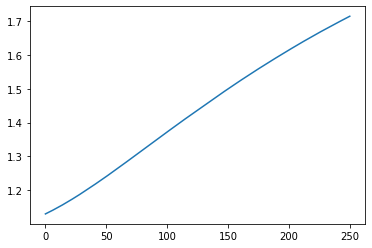

In [14]:
aveFit = [mean(row) for row in zip(*[rep[1] for rep in metaLog])]
plt.plot(aveFit)
plt.show()

83 24 143


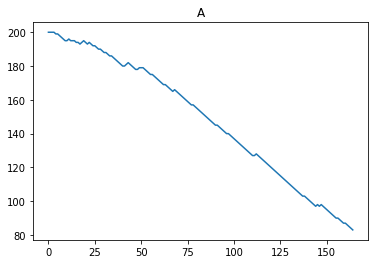

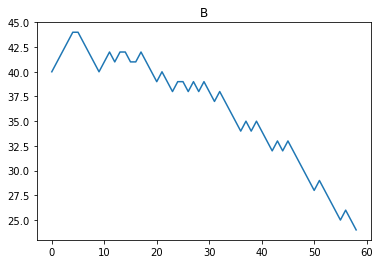

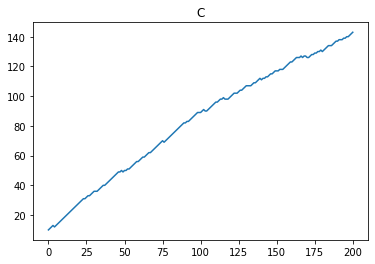

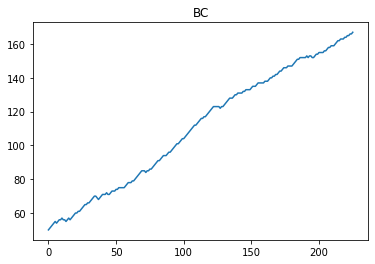

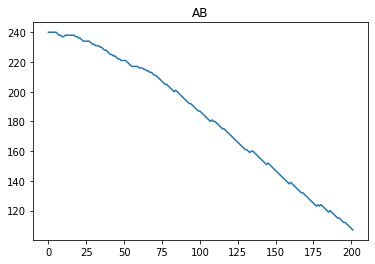

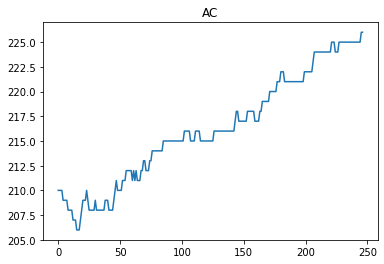

In [15]:
Asize,Bsize,Csize,BCsize, ABsize, ACsize = metaLog[0][0]
print(Asize[-1],Bsize[-1],Csize[-1])
plt.plot(Asize)
plt.title("A")
plt.show()
plt.plot(Bsize)
plt.title("B")
plt.show()
plt.plot(Csize)
plt.title("C")
plt.show()
plt.plot(BCsize)
plt.title("BC")
plt.show()
plt.plot(ABsize)
plt.title("AB")
plt.show()
plt.plot(ACsize)
plt.title("AC")
plt.show()

In [16]:
# listOfDics = []
# for rep in metaLog:
#     finalClades = rep[2]
#     cladeIDcounts = Counter(finalClades)
#     countsCount = Counter(cladeIDcounts.values())
#     countsCount[0] = N-sum(countsCount.values())
#     listOfDics.append(countsCount)

# totals = dictionaryReduce(listOfDics,{})

# dist = {k:mean(v)/N for k,v in sorted(totals.items())}
# error = {k:stdev(v)/N if len(v) > 1 else 0 for k,v in sorted(totals.items())}


# plt.plot(sorted(dist.keys()),[dist[k] for k in sorted(dist.keys())],marker="o",linestyle="",color="r")
# plt.plot(moranDriftReference([N for _ in range(N+1)])[:max(totals.keys())+1],color="k")
# plt.fill_between(sorted(error.keys()),
#                  [dist[k]+(2.58*error[k])/np.sqrt(len(metaLog)) for k in sorted(error.keys())],
#                  [dist[k]-(2.58*error[k])/np.sqrt(len(metaLog)) for k in sorted(error.keys())],
#                  alpha=0.3,color="r",label="99% Confidence interval")
# plt.yscale("log")
# plt.show()
def emd(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])

def emdNEW(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum(EMD)

print(emd([3,0,1,0,2,6],[1,1,5,0,1,4]))
print(emdNEW([3,0,1,0,2,6],[1,1,5,0,1,4]))
print(mean([3,0,1,0,2,6])-mean([1,1,5,0,1,4]))

11
-5
0


POP
SIM of Average
0.76+/-0.09


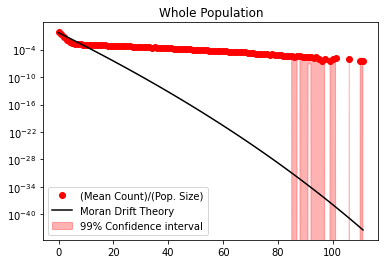

A
SIM of Average
0.0002+/-0.0008


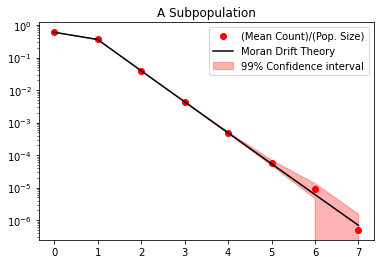

B
SIM of Average
0.0011+/-0.0004


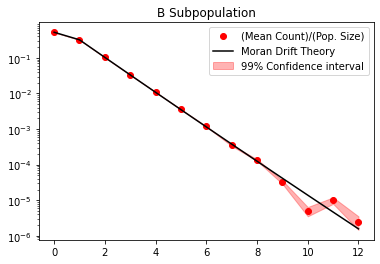

C
SIM of Average
0.061+/-0.011


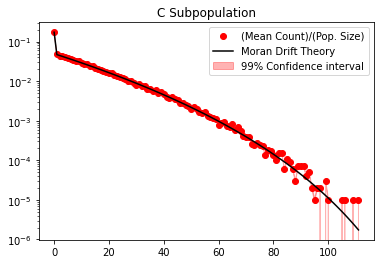

BC
SIM of Average
2.29+/-0.05


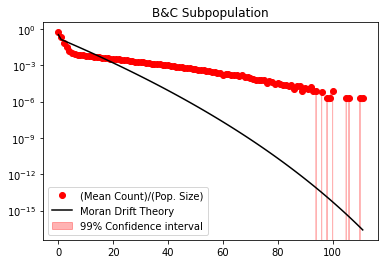

AB
SIM of Average
0.067+/-0.009


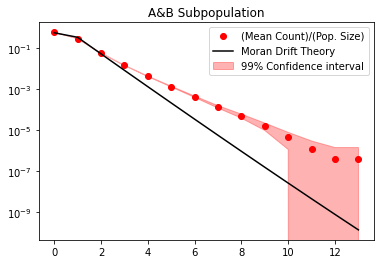

AC
SIM of Average
0.85+/-0.09


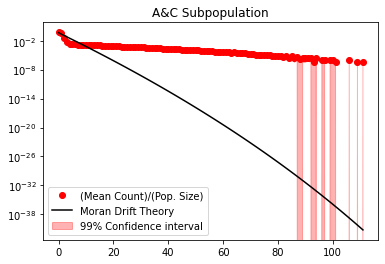

In [34]:
def makePlotFromData(title,listOfFinalClades,listOfGroupSizes):
    listOfDics = []
    listOfRefs = []
    listOfImpacts = []
    for clades,sizes in zip(listOfFinalClades,listOfGroupSizes):
        Ni=sizes[0]
        cladeIDcounts = Counter(clades)
        countsCount = Counter(cladeIDcounts.values())
        countsCount[0] = Ni-sum(countsCount.values())
        listOfDics.append(countsCount)
        localDist = {k:v/Ni for k,v in sorted(countsCount.items())}
        localRef = moranDriftReference(sizes)
        localObs = [localDist[k] if k in localDist else 0 for k in range(max(localDist.keys())+1)]
#         plt.plot(localObs,label="obs",marker="o")
#         plt.plot(localRef[:max(localDist.keys())+1],label="ref")
#         plt.yscale("log")
#         plt.legend()
#         plt.show()
#         listOfImpacts.append(emd(localObs,localRef[:max(localDist.keys())+1]))
        listOfRefs.append(localRef)
#     print("Average SIM, 99ci")
#     print(mean(listOfImpacts),2.58*stdev(listOfImpacts)/np.sqrt(len(listOfImpacts)))
        
    totals = dictionaryReduce(listOfDics,{})
    aveRef = [mean(col) for col in zip_longest_no_fill(*listOfRefs)]# because each replicate might have a dif drift reference
#     print(len(listOfRefs),"refs")
#     print()
#     for thing in zip(*listOfRefs):
#         print(mean(thing))
    
    dist = {k:mean(v)/Ni for k,v in sorted(totals.items())}
    error = {k:stdev(v)/N if len(v) > 1 else 0 for k,v in sorted(totals.items())}

    ### print SIM
#     OBS = [dist[k] for k in range(max(dist.keys())+1)]
    sqrtN = np.sqrt(len(metaLog))
    OBS = [ufloat(dist[k],(2.58*error[k])/sqrtN) for k in range(max(dist.keys())+1)]
#     print(dist.keys())
#     print(aveRef)
    REF = aveRef[:max(dist.keys())+1]
#     print(len(OBS),len(REF))
    SIMor = emd(OBS,REF)
#     SIMro = emd(REF,OBS)
    print("SIM of Average")
    print(SIMor)
#     print([(2.58*error[k])/np.sqrt(len(metaLog)) for k in sorted(error.keys())])
#     plt.plot(OBS,label="obs",marker="o")
#     plt.plot(REF,label="ref")
#     plt.yscale("log")
#     plt.legend()
#     plt.show()
    ###
    plt.plot(sorted(dist.keys()),[dist[k] for k in sorted(dist.keys())],marker="o",linestyle="",
             color="r",label="(Mean Count)/(Pop. Size)")
    plt.plot(aveRef[:max(totals.keys())+1],color="k",label="Moran Drift Theory")
    plt.fill_between(sorted(error.keys()),
                     [dist[k]+(2.58*error[k])/np.sqrt(len(metaLog)) for k in sorted(error.keys())],
                     [dist[k]-(2.58*error[k])/np.sqrt(len(metaLog)) for k in sorted(error.keys())],
                     alpha=0.3,color="r",label="99% Confidence interval")
    plt.yscale("log")
    plt.legend()
    plt.title(title)
    plt.show()



groupSizeLog, fitnessLog, allClades, Aclades, Bclades, Cclades, BCclades, ABclades, ACclades = zip(*metaLog)

#everybody
print("POP")
makePlotFromData("Whole Population",allClades,[[N for _ in range(U+1)] for _ in range(totalReps)])

# A only
print("A")
makePlotFromData("A Subpopulation",Aclades,list(zip(*groupSizeLog))[0])

# B only
print("B")
makePlotFromData("B Subpopulation",Bclades,list(zip(*groupSizeLog))[1])

# C only
print("C")
makePlotFromData("C Subpopulation",Cclades,list(zip(*groupSizeLog))[2])


print("BC")
makePlotFromData("B&C Subpopulation",BCclades,list(zip(*groupSizeLog))[3])

print("AB")
makePlotFromData("A&B Subpopulation",ABclades,list(zip(*groupSizeLog))[4])

print("AC")
makePlotFromData("A&C Subpopulation",ACclades,list(zip(*groupSizeLog))[5])

In [ ]:
2.58*0.06851830398900483/np.sqrt(10000)

In [9]:
# STR = float(10)
# ADV = 1
# N = 500

# p_birth = 0.5
# p_death = 0.43

# population = [Org(i, i//(N//3),ADV) for i in range(N)]

# U = 250

# groupSizeLog = [len(population)]
# fitnessLog = [mean([org.fitness for org in population])]
# for u in range(U):
#     birthIDs = roulette(population,1,STR)
#     deathID = random.randint(0,len(population)-1)
#     child = population[birthIDs[0]].makeMutatedOffspring()
    
#     willBirth = random.random() <= p_birth
#     willDeath = random.random() <= p_death
    
#     if willBirth and willDeath:
#         population[deathID] = child
#     elif willBirth and not willDeath:
#         population.append(child)
#     elif not willBirth and willDeath:
#         population.pop(deathID)
#     else:
#         #no action taken
#         continue #this will skip the group size change update, fixes theory, but also skips fitness log (doesnt matter)  
#     groupSizeLog.append(len(population))
#     fitnessLog.append(mean([org.fitness for org in population]))


In [10]:
# plt.plot(fitnessLog)
# plt.show()

# plt.plot(groupSizeLog,label=["p"])
# plt.legend()
# plt.show()
# print(N,groupSizeLog[-1])
# print(len(groupSizeLog),U+1)

In [11]:
# finalClades = [org.cladeID for org in population]
# # print("final clade IDs",sorted(finalAs))
# Ni= groupSizeLog[0]
# Nf= groupSizeLog[-1]
# cladeIDcounts = Counter(finalClades)
# # print("clade Counts",cladeIDcounts)
# countsCount = Counter(cladeIDcounts.values())
# countsCount[0] = Ni-sum(countsCount.values())
# print("clade count counts",countsCount)
# print(sum([k*v for k,v in countsCount.items()]))
# dist = [v/Ni for k,v in sorted(countsCount.items())]
# plt.plot(sorted(countsCount.keys()),dist,marker="o",linestyle="")
# # print(Asize)
# plt.plot(moranDriftReference(groupSizeLog)[:max(countsCount.keys())+1])
# # plt.plot(moranDriftReference([Asize[0] for _ in range(N+1)])[:max(countsCount.keys())+1])##??
# plt.plot(moranDriftReference([N for _ in range(N+1)])[:max(countsCount.keys())+1])##??
# plt.yscale("log")
# plt.show()

In [12]:
def foo(A={}):
    if 0 not in A:
        A[0] = []
    A[0].append("another one")
    return A

print(foo())
print(foo())

{0: ['another one']}
{0: ['another one', 'another one']}
